### Assigment 4

**Submission deadlines**:

* get at least 4 points by 17.05.2023
* remaining points: last lab session before or on 26.05.2023

**Points:** Aim to get 12 out of 15+ possible points

All needed data files should be on Drive: <https://drive.google.com/drive/folders/1HaMbhzaBxxNa_z_QJXSDCbv5VddmhVVZ?usp=sharing> 

## Task 1 (5 points)

Implement simplified word2vec with negative sampling from scratch (using pure numpy). Assume that in the training data objects and contexts are given explicitly, one pair per line, and objects are on the left. The result of the training should be object vectors. Please, write them to a file using *natural* text format, ie

<pre>
word1 x1_1 x1_2 ... x1_N 
word2 x2_1 x2_2 ... x2_N
...
wordK xK_1 xK_2 ... xk_N
</pre>

Use the loss from Slide 25 in Lecture NLP.01, compute the gradient manually. You can use some gradient clipping, or regularisation. 

**Remark**: the data is specially prepared to make the learning process easier. 
Present vectors using the code below. In this task we define success as 'obtaining a result which looks definitely not random'


In [ ]:
import gzip
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict

import re
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import gensim

In [ ]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/My Drive/task1_objects_contexts_polish.txt.gz"
else:
    path = "task1_objects_contexts_polish.txt.gz"
    
with gzip.open(path, 'rt') as f:
    content = [line.strip() for line in f.readlines()]
    objects = [c.split()[0] for c in content]
    contexts = [c.split()[1].split("_")[-1] for c in content]
    del content

In [ ]:
class DataLoader(object):
    def __init__(self, objects, contexts, batch_size=256):
        self.tokens = list(set(objects + contexts))
        self.word_to_ind, self.ind_to_word = self.get_mapping(self.tokens)
        self.vocab_size = len(self.word_to_ind)

        self.X, self.Y = self.preprocess_data(objects, contexts, self.word_to_ind, self.ind_to_word)

        self.batch_size = batch_size
        self.batch_inds = list(range(0, self.X.shape[0], batch_size))

        self.get_unigram_distr()

    def __iter__(self):
        for i in self.batch_inds:
            #Y_one_hot = np.zeros((self.batch_size, self.vocab_size))
            #Y_one_hot[np.arange(self.batch_size), self.Y[i:i + self.batch_size, :].flatten()] = 1
            yield self.X[i:i + self.batch_size, :], self.Y[i:i + self.batch_size, :]#Y_one_hot

    def __len__(self):
        return len(self.batch_inds)

    def get_unigram_distr(self):
        
        word_count = defaultdict(int)

        for ind in self.X.flatten():
            word_count[ind] += 1

        for ind in self.Y.flatten():
            word_count[ind] += 1

        self.unigrams = list(word_count.keys())
        
        unigrams_count = list(c**(3/4) for c in word_count.values())
        summ = sum(unigrams_count)

        self.unigrams_count = list(word_count.values())

        self.unigrams_distributions = list(c / summ for c in unigrams_count)

    def get_mapping(self, tokens):
        word_to_ind = dict()
        ind_to_word = dict()
        for ind, word in enumerate(tokens):
            word_to_ind[word] = ind
            ind_to_word[ind] = word
        return word_to_ind, ind_to_word

    def preprocess_data(self, objects, contexts, word_to_ind, ind_to_word):
        ''' Preprocess X and Y as vector of indices
            one hot input means that we take the i-th row from ebeddings matrix.
        '''
        dict_size = len(word_to_ind)

        X = []
        Y = []
        for i in range(len(objects)):
            X.append(word_to_ind[objects[i]])
            
            y_ind = word_to_ind[contexts[i]]
            Y.append(y_ind)

        return np.expand_dims(np.array(X),axis=1), np.expand_dims(np.array(Y), axis=1) 

In [ ]:
word_count = defaultdict(int)
for w in list(objects + contexts):
    word_count[w] += 1

In [ ]:
reduced_objects = []
reduced_contexts = []
min_count = 500
for i in range(len(objects)):
    if word_count[objects[i]] >= min_count and word_count[contexts[i]] >= min_count:
        reduced_objects.append(objects[i])
        reduced_contexts.append(contexts[i])


In [ ]:
len(reduced_contexts), len(reduced_objects), len(objects), sum(np.array(list(word_count.values())) >= min_count)

(1993858, 1993858, 5525116, 5386)

In [ ]:
words_loader = DataLoader(reduced_objects, reduced_contexts, batch_size=1)
vocab_size = words_loader.vocab_size

unigram_ind = words_loader.unigrams
unigram_distr = words_loader.unigrams_distributions
unigrams_count = words_loader.unigrams_count

In [ ]:
class Word2Vec:
    def __init__(self, vocab_size, emb_size, unigram_ind, unigram_distr, K=10, dtype=np.float32):
        self.EMB = np.zeros((vocab_size, emb_size), dtype=dtype)
        self.DENSE = np.zeros((emb_size, vocab_size), dtype=dtype)

        self.K = K
        self.unigram_ind = unigram_ind
        self.unigram_distr = unigram_distr

        self.init_params()

    def init_params(self):
        mu, std = 0, 0.5
        self.EMB = np.random.normal(mu, std, size=self.EMB.shape)
        self.DENSE =  np.random.normal(mu, std, size=self.DENSE.shape)
    
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))

    def backward_forward(self, x_ind, y_ind, alpha=0.003, calc_output=False):

        center_word = self.EMB[x_ind, :]
        context_word = self.DENSE[:, y_ind]

        sampled_contexts_id = np.random.choice(self.unigram_ind, size=self.K, replace=False, p=self.unigram_distr)
        negative_words = self.DENSE[:, sampled_contexts_id]
        
        if calc_output:
            output = center_word @ self.DENSE
        else:
            output = None

    
        loss_poss = -np.log(self.sigmoid(center_word @ context_word))
        loss_neg = -np.sum(np.log(self.sigmoid(center_word @ negative_words)), axis=1) 
        loss = float(loss_poss + loss_neg)

        center_word_grad  = (self.sigmoid(center_word @ context_word) - 1) * context_word.reshape(1,-1)
        negatives = self.sigmoid(center_word @ negative_words).flatten()
        for i in range(negatives.shape[0]):
            center_word_grad += negatives[i] * negative_words[:, i].reshape(1, -1)

        context_word_grad = (self.sigmoid(center_word @ context_word) - 1) * center_word.reshape(-1, 1)

        negative_word_grad = np.zeros(shape=negative_words.shape)
        for i in range(negatives.shape[0]):
            negative_word_grad[:, i] = negatives[i] * center_word
        
        self.EMB[x_ind, :] = self.EMB[x_ind, :] - alpha * center_word_grad
        self.DENSE[:, y_ind] = self.DENSE[:, y_ind] - alpha * context_word_grad
        self.DENSE[:, sampled_contexts_id] = self.DENSE[:, sampled_contexts_id] - alpha * negative_word_grad

        return output, loss, loss_poss, loss_neg

In [ ]:
word2vec = Word2Vec(vocab_size, 50, unigram_ind, unigram_distr, K=10)

In [ ]:
log_iter = 100000
num_epoch = 4

for epoch in range(num_epoch):
    avg_loss, avg_pos_loss, i = 0, 0, 0
    for x,y in tqdm(words_loader):
        i += 1

        x, y = x.flatten(), y.flatten()

        o, loss, l_p, l_n = word2vec.backward_forward(x,y, alpha=0.005)

        avg_loss += loss
        avg_pos_loss += float(l_p)

        if i % log_iter == 0:
            #print(x, words_loader.ind_to_word[int(x)])
            #print(y, words_loader.ind_to_word[int(y)])
            print(f"epoch: {epoch}, avg loss: {avg_loss / i:.2f}, avg pos loss: {avg_pos_loss / i:.4f}")
            
        del x
        del y
        
    print(f"end of epoch: {epoch}, avg loss: {avg_loss / i:.2f}, avg pos loss: {avg_pos_loss / i:.4f}")

  0%|          | 0/1993858 [00:00<?, ?it/s]

epoch: 0, avg loss: 10.71, avg pos loss: 0.9709
epoch: 0, avg loss: 10.48, avg pos loss: 0.9499
epoch: 0, avg loss: 10.30, avg pos loss: 0.9320
epoch: 0, avg loss: 10.18, avg pos loss: 0.9220
epoch: 0, avg loss: 10.16, avg pos loss: 0.9207
epoch: 0, avg loss: 10.31, avg pos loss: 0.9348
epoch: 0, avg loss: 10.72, avg pos loss: 0.9723
epoch: 0, avg loss: 11.41, avg pos loss: 1.0351
epoch: 0, avg loss: 12.30, avg pos loss: 1.1155
epoch: 0, avg loss: 13.29, avg pos loss: 1.2043
epoch: 0, avg loss: 14.28, avg pos loss: 1.2930
epoch: 0, avg loss: 15.22, avg pos loss: 1.3764
epoch: 0, avg loss: 16.09, avg pos loss: 1.4530
epoch: 0, avg loss: 16.87, avg pos loss: 1.5218
epoch: 0, avg loss: 17.58, avg pos loss: 1.5832
epoch: 0, avg loss: 18.21, avg pos loss: 1.6384
epoch: 0, avg loss: 18.78, avg pos loss: 1.6878
epoch: 0, avg loss: 19.29, avg pos loss: 1.7320
epoch: 0, avg loss: 19.76, avg pos loss: 1.7719
end of epoch: 0, avg loss: 20.16, avg pos loss: 1.8058


  0%|          | 0/1993858 [00:00<?, ?it/s]

epoch: 1, avg loss: 28.20, avg pos loss: 2.4672
epoch: 1, avg loss: 28.22, avg pos loss: 2.4683
epoch: 1, avg loss: 28.23, avg pos loss: 2.4681
epoch: 1, avg loss: 28.24, avg pos loss: 2.4689
epoch: 1, avg loss: 28.25, avg pos loss: 2.4693
epoch: 1, avg loss: 28.25, avg pos loss: 2.4688
epoch: 1, avg loss: 28.26, avg pos loss: 2.4679
epoch: 1, avg loss: 28.26, avg pos loss: 2.4668
epoch: 1, avg loss: 28.25, avg pos loss: 2.4652
epoch: 1, avg loss: 28.25, avg pos loss: 2.4639
epoch: 1, avg loss: 28.25, avg pos loss: 2.4620
epoch: 1, avg loss: 28.24, avg pos loss: 2.4601
epoch: 1, avg loss: 28.24, avg pos loss: 2.4586
epoch: 1, avg loss: 28.23, avg pos loss: 2.4569
epoch: 1, avg loss: 28.23, avg pos loss: 2.4552
epoch: 1, avg loss: 28.22, avg pos loss: 2.4535
epoch: 1, avg loss: 28.21, avg pos loss: 2.4520
epoch: 1, avg loss: 28.21, avg pos loss: 2.4503
epoch: 1, avg loss: 28.20, avg pos loss: 2.4489
end of epoch: 1, avg loss: 28.19, avg pos loss: 2.4475


  0%|          | 0/1993858 [00:00<?, ?it/s]

epoch: 2, avg loss: 28.04, avg pos loss: 2.3970
epoch: 2, avg loss: 28.02, avg pos loss: 2.3966
epoch: 2, avg loss: 28.02, avg pos loss: 2.3957
epoch: 2, avg loss: 28.01, avg pos loss: 2.3953
epoch: 2, avg loss: 28.01, avg pos loss: 2.3947
epoch: 2, avg loss: 28.00, avg pos loss: 2.3935
epoch: 2, avg loss: 28.00, avg pos loss: 2.3920
epoch: 2, avg loss: 27.99, avg pos loss: 2.3904
epoch: 2, avg loss: 27.98, avg pos loss: 2.3884
epoch: 2, avg loss: 27.98, avg pos loss: 2.3868
epoch: 2, avg loss: 27.97, avg pos loss: 2.3847
epoch: 2, avg loss: 27.97, avg pos loss: 2.3827
epoch: 2, avg loss: 27.96, avg pos loss: 2.3808
epoch: 2, avg loss: 27.96, avg pos loss: 2.3788
epoch: 2, avg loss: 27.95, avg pos loss: 2.3767
epoch: 2, avg loss: 27.95, avg pos loss: 2.3747
epoch: 2, avg loss: 27.94, avg pos loss: 2.3728
epoch: 2, avg loss: 27.94, avg pos loss: 2.3708
epoch: 2, avg loss: 27.94, avg pos loss: 2.3689
end of epoch: 2, avg loss: 27.93, avg pos loss: 2.3671


  0%|          | 0/1993858 [00:00<?, ?it/s]

epoch: 3, avg loss: 27.86, avg pos loss: 2.3103
epoch: 3, avg loss: 27.87, avg pos loss: 2.3093
epoch: 3, avg loss: 27.87, avg pos loss: 2.3078
epoch: 3, avg loss: 27.88, avg pos loss: 2.3066
epoch: 3, avg loss: 27.88, avg pos loss: 2.3051
epoch: 3, avg loss: 27.88, avg pos loss: 2.3032
epoch: 3, avg loss: 27.89, avg pos loss: 2.3009
epoch: 3, avg loss: 27.89, avg pos loss: 2.2986
epoch: 3, avg loss: 27.90, avg pos loss: 2.2960
epoch: 3, avg loss: 27.90, avg pos loss: 2.2935
epoch: 3, avg loss: 27.91, avg pos loss: 2.2907
epoch: 3, avg loss: 27.91, avg pos loss: 2.2879
epoch: 3, avg loss: 27.92, avg pos loss: 2.2853
epoch: 3, avg loss: 27.92, avg pos loss: 2.2825
epoch: 3, avg loss: 27.93, avg pos loss: 2.2798
epoch: 3, avg loss: 27.94, avg pos loss: 2.2770
epoch: 3, avg loss: 27.95, avg pos loss: 2.2744
epoch: 3, avg loss: 27.96, avg pos loss: 2.2716
epoch: 3, avg loss: 27.96, avg pos loss: 2.2690
end of epoch: 3, avg loss: 27.97, avg pos loss: 2.2665


In [ ]:
with open("task1_w2v_vectors.txt", "w") as f:  
    for ind in words_loader.ind_to_word.keys():
        f.write(words_loader.ind_to_word[ind])
        f.write(" ")
        f.write(str(word2vec.EMB[ind, :]).replace("[", "").replace("]", ""))
        f.write("\n")

In [ ]:
with open("task1_w2v_vectors.txt", "r") as file:
    file_contents = file.read()

In [ ]:
word_embeddings = []
embedding = []
for x in file_contents.split():
    try:
        y = float(x)
        embedding.append(x)
    except:
        word_embeddings.append(" ".join(embedding))
        embedding = []
        embedding.append(str(x))
word_embeddings.remove("")
word_embeddings.insert(0, " ".join([f"{len(word_embeddings)}", '50']))
with open("task1_w2v_vectors_2.txt", "w") as file:
    file.write("\n".join(word_embeddings))

In [ ]:
words_loader.word_to_ind.keys()

dict_keys(['futro', 'ocean', 'sojusz', 'trupa', 'myśleć', 'lepper', 'poznać', 'fortepian', 'galeria', 'częsty', 'detektyw', 'sąsiedztwo', 'płaszcz', 'nadzieja', 'pokolenie', 'kategoria', 'środek', 'rodzic', 'rozpoczynać', 'pył', 'metr', 'tom', 'wykład', 'proponować', 'poczta', 'lęk', 'ola', 'korporacja', 'łukasz', 'lód', 'kapitał', 'doba', 'wypaść', 'codzienny', 'odbierać', 'demonstracja', 'wewnętrzny', 'lato', 'koszykarka', 'starostwo', 'upodobanie', 'hitler', 'zmniejszenie', 'powieka', 'pełnomocnik', 'skrzydło', 'koza', 'popularność', 'późniejszy', 'duma', 'przygotowywanie', 'wyjechać', 'pot', 'okolica', 'wątek', 'detal', 'artykuł', 'rejestrowanie', 'wielkość', 'miąć', 'antena', 'mieszanka', 'rodzinny', 'luda', 'tancerz', 'kół', 'pieczątka', 'płuco', 'arek', 'rówieśnik', 'blokowanie', 'upokorzenie', 'zagadnienie', 'tytoń', 'dojrzałość', 'kwatera', 'inżynier', 'ojczyzna', 'ireneusz', 'mieszkaniec', 'esej', 'umysł', 'marysia', 'specjalność', 'przekształcenie', 'oczyszczenie', 'integrac

In [ ]:
task1_wv = KeyedVectors.load_word2vec_format('task1_w2v_vectors_2.txt', binary=False)

example_polish_words = ['pies', 'smok', 'miłość', 'rower', 'myśleć', 'logika', 'galeria']

example_words = example_polish_words

for w0 in example_words:
    print ('WORD:', w0)
    for w, v in task1_wv.most_similar(w0):
        print ('   ', w, v)
    print ()

WORD: pies
    głowa 0.8123483061790466
    oko_oka 0.8101950883865356
    twarz 0.7974109649658203
    zaraza 0.7940031886100769
    tył 0.7891573309898376
    beza 0.7861111164093018
    oko_oczy 0.7842614054679871
    broń 0.7737311124801636
    widok 0.771806001663208
    ręka 0.7709239721298218

WORD: smok
    pomnik 0.7751135230064392
    zaraza 0.7588642835617065
    wiatr 0.7346553206443787
    słońce 0.7299768924713135
    sam 0.7234453558921814
    siostra 0.7216556668281555
    krzyż 0.7206531167030334
    obraza 0.7189865708351135
    jeleń 0.7187168598175049
    oko_oka 0.7170244455337524

WORD: miłość
    symbol 0.8798370361328125
    tajemnica 0.869478166103363
    życie 0.850462794303894
    prawda 0.8486914038658142
    szacunek 0.8417799472808838
    człowiek 0.8412559032440186
    nadzieja 0.8364151120185852
    historia 0.8295959830284119
    pragnienie 0.8277696371078491
    doświadczenie 0.8231015801429749

WORD: rower
    kamera 0.7890463471412659
    sylwetka 0.

## Task 2 (4 points)

Your task is to train the embeddings for Simple Wikipedia titles, using gensim library. As the example below shows, training is really simple:

```python
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
```
*sentences* can be a list of list of tokens, you can also use *gensim.models.word2vec.LineSentence(source)* to create restartable iterator from file. At first, use [this file] containing such pairs of titles, that one article links to another.

We say that two titles are *related* if they both contain a word (or a word bigram) which is not very popular (it occurs only in several titles). Make this definition more precise, and create the corpora which contains pairs of related titles. Make a mixture of the original corpora, and the new one, then train title vectors again.

Compare these two approaches using similar code to the code from Task 1.

In [ ]:
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
class WikiLink:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, path = "task2_simple.wiki.links.txt.gz"):
        self.path = path
    
    def __iter__(self):
        with gzip.open(self.path, 'rt') as f:
            for line in f:
                yield line.strip().split()
                
wiki_corpora = WikiLink()

In [ ]:
class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        print("Model loss:", model.get_latest_training_loss())  # print loss
        self.epoch += 1
        
    def on_train_end(self, model):
        print("Training end")
        print("Model loss:", model.get_latest_training_loss())

In [ ]:
logger = EpochLogger()
model = Word2Vec(
    sentences=wiki_corpora, 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4,
    callbacks=[logger])
model.save("word2vec.model")

Epoch #0 start
Epoch #0 end
Model loss: 0.0
Epoch #1 start
Epoch #1 end
Model loss: 0.0
Epoch #2 start
Epoch #2 end
Model loss: 0.0
Epoch #3 start
Epoch #3 end
Model loss: 0.0
Epoch #4 start
Epoch #4 end
Model loss: 0.0
Training end
Model loss: 0.0


In [ ]:
model = gensim.models.Word2Vec.load("word2vec.model")

In [ ]:
model.wv.key_to_index

{'united_states': 0,
 'help:gadget-hotcat': 1,
 'category:living_people': 2,
 'france': 3,
 'wikipedia:database_reports/templates_without_templatedata': 4,
 'project:awb': 5,
 'communes_of_france': 6,
 'lincoln_near-earth_asteroid_research': 7,
 'socorro,_nm': 8,
 'd:': 9,
 'c:help:cat-a-lot': 10,
 'americans': 11,
 'japan': 12,
 'departments_of_france': 13,
 'germany': 14,
 'city': 15,
 'association_football': 16,
 'kitt_peak_national_observatory': 17,
 'fin_tbl#405': 18,
 'spacewatch': 19,
 'u.s._state': 20,
 'help:archiving_a_talk_page': 21,
 'fin_tbl#401': 22,
 'england': 23,
 'en:wp:dbug': 24,
 'en:wp:ucb': 25,
 'italy': 26,
 '2010_united_states_census': 27,
 'near-earth_asteroid_tracking': 28,
 'fin_tbl#402': 29,
 'palomar_observatory': 30,
 'united_kingdom': 31,
 'india': 32,
 'regions_of_france': 33,
 'user:djsasso': 34,
 'new_york_city': 35,
 'user_talk:djsasso': 36,
 'california': 37,
 'user:auntof6': 38,
 'sweden': 39,
 'user_talk:auntof6': 40,
 'democratic_party_(united_sta

In [ ]:
example_words = ["regions_of_france", "canada", "actor", 
                 "world_war_ii", "animal", "rome"]

for w0 in example_words:
    print ('WORD:', w0)
    for w, v in model.wv.most_similar(w0):
        print ('   ', w, v)
    print ()

WORD: regions_of_france
    departments_of_france 0.9970690608024597
    communes_of_france 0.9919934272766113
    pays_de_la_loire 0.985201358795166
    commune_in_france 0.9680162668228149
    nord-pas-de-calais 0.9632577896118164
    somme 0.9613362550735474
    communes_of_the_pas-de-calais_department 0.9582456946372986
    category:communes_in_pas-de-calais 0.9574025273323059
    pas-de-calais 0.9555525183677673
    template:pas-de-calais_communes 0.9546453952789307

WORD: canada
    toronto 0.8745865821838379
    british_columbia 0.8680064082145691
    ontario 0.8640695214271545
    quebec 0.8581305742263794
    vancouver 0.8475488424301147
    usa 0.8369801640510559
    coast_mountains 0.8261826038360596
    alberta 0.8100963830947876
    montreal 0.8075870275497437
    ottawa 0.8063203692436218

WORD: actor
    singer 0.9838047027587891
    television 0.980603814125061
    actress 0.980118989944458
    movie 0.9645726084709167
    comedian 0.9542132019996643
    movie_director 

In [ ]:
def get_counts(corpora_pairs):
    unigrams = defaultdict(int)
    bigrams = defaultdict(int)
    wrong_titles = 0
    
    for title_pair in corpora_pairs:
        if len(title_pair) == 2:
            title_1 = re.split(r'_|:|\\|\/|-', title_pair[0])
            title_2 = re.split(r'_|:|\\|\/|-', title_pair[1])
            title_1 = [w for w in title_1 if len(w) > 0]
            title_2 = [w for w in title_2 if len(w) > 0]
            
            for i in range(len(title_1)):
                w1 = title_1[i]
                unigrams[w1] += 1

                if i < len(title_1) - 1:
                    w2 = title_1[i + 1]
                    bigrams[(w1, w2)] += 1

            for i in range(len(title_2)):
                w1 = title_2[i]
                unigrams[w1] += 1

                if i < len(title_2) - 1:
                    w2 = title_2[i + 1]
                    bigrams[(w1, w2)] += 1
        else:
            wrong_titles +=1
            
    print(f"Found {wrong_titles} wrong title pairs")
    return unigrams, bigrams

In [ ]:
unigrams, bigrams = get_counts(wiki_corpora)

Found 545 wrong title pairs


Create a set of rare unigrams such that, the sum of all occurrences of unigrams in this set is around 10% of occurences of all unigrams

Similarly with bigrams

In [ ]:
print("UNIGRRAMS")
counts = np.array(list(unigrams.values()))
uni_sum = sum(counts)
for uni_threshold in [10, 25, 40, 60, 80, 400]:
    print(f"For threshold {uni_threshold} : {sum(counts[counts <= uni_threshold]) / uni_sum * 100:.3f} % of all occurrences ")
    
#uni_quantiles = np.quantile(counts, split)
#print(uni_quantiles)

print("\nBIGRAMS")
counts = np.array(list(bigrams.values()))
bi_sum = sum(counts)
for bi_threshold in [3, 5, 10, 12, 35]:
    print(f"For threshold {bi_threshold} : {sum(counts[counts <= bi_threshold]) / bi_sum * 100:.3f} % of all occurrences ")
    
#bi_quantiles = np.quantile(counts, split)
#print(bi_quantiles)

UNIGRRAMS
For threshold 10 : 2.586 % of all occurrences 
For threshold 25 : 4.842 % of all occurrences 
For threshold 40 : 6.712 % of all occurrences 
For threshold 60 : 8.579 % of all occurrences 
For threshold 80 : 10.023 % of all occurrences 
For threshold 400 : 19.560 % of all occurrences 

BIGRAMS
For threshold 3 : 5.774 % of all occurrences 
For threshold 5 : 7.097 % of all occurrences 
For threshold 10 : 9.431 % of all occurrences 
For threshold 12 : 10.380 % of all occurrences 
For threshold 35 : 20.996 % of all occurrences 


In [ ]:
def get_bigrams(sentence : list):
    bigrams = []
    for i in range(len(sentence) - 1):
        w1 = sentence[i]
        w2 = sentence[i + 1]
        bigrams.append((w1, w2))
    
    return bigrams

In [ ]:
def get_related_pairs(uni_threshold, bi_threshold, corpora_pairs, unigrams, bigrams):
    related_titles = []
    for title_pair in corpora_pairs:
        if len(title_pair) == 2:
            title_1 = re.split(r'_|:|\\|\/|-', title_pair[0])
            title_2 = re.split(r'_|:|\\|\/|-', title_pair[1])
            title_1 = [w for w in title_1 if len(w) > 0]
            title_2 = [w for w in title_2 if len(w) > 0]

            A = set(title_1)
            B = set(title_2)
            shared_unigrams = A.intersection(B)

            found = False
            for s_u in shared_unigrams:
                if unigrams[s_u] <= uni_threshold:
                    related_titles.append(title_pair)
                    found = True
                    break

            if not found:
                bigrams_1 = get_bigrams(title_1)
                bigrams_2 = get_bigrams(title_2)

                A = set(bigrams_1)
                B = set(bigrams_2)
                shared_bigrams = A.intersection(B)

                for s_b in shared_bigrams:
                    if bigrams[s_b] <= bi_threshold:
                        related_titles.append(title_pair)
                        found = True
                        break
        
    return related_titles

In [ ]:
uni_threshold = 400
bi_threshold = 35
related_titles = get_related_pairs(uni_threshold, bi_threshold, wiki_corpora, unigrams, bigrams)

In [ ]:
corpora_len = 0
for p in wiki_corpora:
    corpora_len += 1

In [ ]:
len(related_titles), corpora_len

(201858, 7571390)

In [ ]:
logger = EpochLogger()
model_2 = Word2Vec(
    sentences=related_titles, 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4,
    callbacks=[logger])
model_2.save("word2vec_2.model")

Epoch #0 start
Epoch #0 end
Model loss: 0.0
Epoch #1 start
Epoch #1 end
Model loss: 0.0
Epoch #2 start
Epoch #2 end
Model loss: 0.0
Epoch #3 start
Epoch #3 end
Model loss: 0.0
Epoch #4 start
Epoch #4 end
Model loss: 0.0
Training end
Model loss: 0.0


In [ ]:
model_2.wv.key_to_index

{'chusquea': 0,
 'cirsium': 1,
 'castilleja': 2,
 'bolitoglossa': 3,
 'template:greater_manchester_metrolink_stations': 4,
 'category:suspected_sockpuppets': 5,
 'atelopus': 6,
 'leucadendron': 7,
 'deseret_alphabet': 8,
 'cupa_româniei': 9,
 'template:huawei': 10,
 'buick': 11,
 'syzygium': 12,
 'arad_county': 13,
 'scinax': 14,
 'bomberman': 15,
 'angelina_jolie': 16,
 'legionella': 17,
 'category:infobox_nfl_biography_currentteam_parameter_tracking_categories': 18,
 'category:septa_templates': 19,
 'hymenocallis': 20,
 'bipalium': 21,
 'hartley': 22,
 'candida': 23,
 'taifa': 24,
 'argus': 25,
 'bohol_(province)': 26,
 'template:ancestry_of_new_zealanders': 27,
 'template:fasa_county': 28,
 'bartonella': 29,
 'qin_shi_huang': 30,
 'heliotropium': 31,
 'dianthus': 32,
 'mimicry': 33,
 'coppa_acerbo': 34,
 'template:categoría_primera_a_top_scorers': 35,
 'wakayama_prefecture': 36,
 "now_that's_what_i_call_music!_(u.s._series)": 37,
 'wikipedia:requests_for_importer/ottava_rima': 38,
 

In [ ]:
example_words = ["peugeot", "porsche"]

for w0 in example_words:
    print ('WORD:', w0)
    for w, v in model_2.wv.most_similar(w0):
        print ('   ', w, v)
    print ()

WORD: peugeot
    three_smart_girls_grow_up 0.43015560507774353
    stevie_nicks_discography 0.40667444467544556
    file:olympic_rings_without_rims.svg 0.4027261734008789
    sentence 0.3919011354446411
    category:1116 0.39004307985305786
    template:coor_title_d/doc 0.38352149724960327
    :en:template:cycling_data_tdd 0.38173651695251465
    francisco_herrera_the_elder 0.3796098232269287
    sara_widén 0.3793408274650574
    file:paavo_lonkila.jpg 0.37480831146240234

WORD: porsche
    image:escudo_de_sanlúcar_la_mayor_(sevilla).svg 0.46046730875968933
    john_g._diefenbaker 0.40606480836868286
    campylobacter_fetus 0.4048357605934143
    category:sash!_songs 0.40355557203292847
    shaft_(company) 0.4015985131263733
    alto_río_senguer_airport 0.4012328088283539
    el_lebrijano 0.394106924533844
    scenario_paintball 0.39263179898262024
    of_plymouth_plantation 0.3879973590373993
    morning_musume_otomegumi 0.3851163983345032



In [ ]:
class WikiLink_2:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, related_titles, path = "task2_simple.wiki.links.txt.gz"):
        self.path = path
        self.related_titles = related_titles
    
    def __iter__(self):
        for title_pair in related_titles:
            yield title_pair
            
        with gzip.open(self.path, 'rt') as f:
            for line in f:
                yield line.strip().split()
                
wiki_corpora_2 = WikiLink_2(related_titles)

In [ ]:
logger = EpochLogger()
model_3 = Word2Vec(
    sentences=wiki_corpora_2, 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4,
    callbacks=[logger])
#model_3.save("word2vec_3.model")

Epoch #0 start
Epoch #0 end
Model loss: 0.0
Epoch #1 start
Epoch #1 end
Model loss: 0.0
Epoch #2 start
Epoch #2 end
Model loss: 0.0
Epoch #3 start
Epoch #3 end
Model loss: 0.0
Epoch #4 start
Epoch #4 end
Model loss: 0.0
Training end
Model loss: 0.0


In [ ]:
example_words = ["regions_of_france", "canada", "actor", 
                 "world_war_ii", "animal", "rome"]

for w0 in example_words:
    print ('WORD:', w0)
    for w, v in model_3.wv.most_similar(w0):
        print ('   ', w, v)
    print("OLD model:")   
    for w, v in model.wv.most_similar(w0):
        print ('   ', w, v)
    print ()

WORD: regions_of_france
    departments_of_france 0.9972414970397949
    communes_of_france 0.9942829012870789
    pays_de_la_loire 0.9820725917816162
    commune_in_france 0.9669280052185059
    nord-pas-de-calais 0.9584699869155884
    pas-de-calais 0.956687331199646
    communes_of_the_pas-de-calais_department 0.9562075138092041
    template:pas-de-calais_communes 0.954113781452179
    category:communes_in_pas-de-calais 0.9539942145347595
    picardie 0.9518336653709412
OLD model:
    departments_of_france 0.9970690608024597
    communes_of_france 0.9919934272766113
    pays_de_la_loire 0.985201358795166
    commune_in_france 0.9680162668228149
    nord-pas-de-calais 0.9632577896118164
    somme 0.9613362550735474
    communes_of_the_pas-de-calais_department 0.9582456946372986
    category:communes_in_pas-de-calais 0.9574025273323059
    pas-de-calais 0.9555525183677673
    template:pas-de-calais_communes 0.9546453952789307

WORD: canada
    british_columbia 0.873909056186676
    to

# Task 3 (4 points)

Suppose that we have two languages: Upper and Lower. This is an example Upper sentence:

<pre>
THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.
</pre>

And this is its translation into Lower:

<pre>
the quick brown fox jumps over the lazy dog
</pre>

You have two corpora for these languages (with different sentences). Your task is to train word embedings for both languages together, so as to make embeddings of the words which are its translations as close as possible. But unfortunately, you have the budget which allows you to prepare the translation only for 1000 words (we call it D, you have to deside which words you want to be in D)

Prepare the corpora wich contains three kind of sentences:
* Upper corpus sentences
* Lower corpus sentences
* sentences derived from Upper/Lower corpus, modified using D

There are many possible ways of doing this, for instance this one (ROT13.COM: hfr rirel fragrapr sebz obgu pbecben gjvpr: jvgubhg nal zbqvsvpngvbaf, naq jvgu rirel jbeqf sebz Q ercynprq ol vgf genafyngvba)

We define the score for an Upper WORD as  $\frac{1}{p}$, where $p$ is a position of its translation in the list of **Lower** words most similar to WORD. For instance, when most similar words to DOG are:

<pre>
WOLF, CAT, WOLVES, LION, gopher, dog
</pre>

then the score for the word DOG is 0.5. Compute the average score separately for words from D, and for words out of D (hint: if the computation takes to much time do it for a random sample).


In [ ]:
class Corpora:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, path):
        self.path = path
    
    def __iter__(self):
        with gzip.open(self.path, 'rt') as f:
            for line in f:
                yield line.strip().split()
            
polish_lower = Corpora("task3_polish_lower.txt.gz")
polish_upper = Corpora("task3_polish_upper.txt.gz")

In [ ]:
# idea:
# use in D the most popular words (with some minimal length)

lower_unigrams = defaultdict(int)
for sen in polish_lower:
    for w in sen:
        if len(w) >= 3:
            lower_unigrams[w] += 1
    
upper_unigrams = defaultdict(int)
for sen in polish_upper:
    for w in sen:
        if len(w) >= 3:
            upper_unigrams[w] += 1

In [ ]:
def get_most_popular_words(unigrams, size=500):
    words = list(unigrams.keys())
    counts = np.array(list(unigrams.values()))
    
    f_words = []
    f_counts = []
    # filter words with letters only
    for i in range(len(words)):
        w = words[i]
        c = counts[i]
        
        if re.match(r'^[A-Za-zĄąĆćĘęŁłŃńÓóŚśŹźŻż]+$', w):
            f_words.append(w)
            f_counts.append(c)
    
    probs = f_counts / sum(f_counts)
    
    most_popular = list(np.random.choice(f_words, p=probs, size=size, replace=False))
    
    return most_popular

def create_dict(lower_words, upper_words, size=1000):
    low2up = dict()
    up2low = dict()
    
    
    for i in range(len(lower_words)):
        l_word = lower_words[i]
        u_word = l_word.upper()
        
        low2up[l_word] = u_word
        up2low[u_word] = l_word
        
        # check if size is achieved
        if len(low2up) == size:
            break
            
        u_word = upper_words[i]
        l_word = u_word.lower()
        
        low2up[l_word] = u_word
        up2low[u_word] = l_word
        
        # check if size is achieved
        if len(low2up) == size:
            break
            
    return low2up, up2low

In [ ]:
# sample more words in case there are some duplicates (we will cast the sum to 'size' later)
size = 1000
popular_lower_words = get_most_popular_words(lower_unigrams, size=size)
popular_upper_words = get_most_popular_words(upper_unigrams, size=size)

low2up, up2low = create_dict(popular_lower_words, popular_upper_words, size=size)

len(popular_lower_words), len(popular_upper_words), len(low2up), len(up2low)

(10000, 10000, 10000, 10000)

In [ ]:
class ModifiedCorpora:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, path, dictionary):
        self.path = path
        self.dict = dictionary
    
    def __iter__(self):
        with gzip.open(self.path, 'rt') as f:
            for line in f:
                sen = line.strip().split()
                sen = [self.dict[w] if w in self.dict else w for w in sen]
                yield sen
                
mod_polish_lower = ModifiedCorpora("task3_polish_lower.txt.gz", low2up)
mod_polish_upper = ModifiedCorpora("task3_polish_upper.txt.gz", up2low)

class JoinedCorpora:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, *corpora):
        self.corpora = corpora
    
    def __iter__(self):
        for c in self.corpora:
            for sen in c:
                yield sen
                
corpora = JoinedCorpora(mod_polish_upper, polish_lower, mod_polish_lower, polish_upper)

In [ ]:
logger = EpochLogger()
model = Word2Vec(
    sentences=corpora, 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4,
    callbacks=[logger])

Epoch #0 start
Epoch #0 end
Model loss: 0.0
Epoch #1 start
Epoch #1 end
Model loss: 0.0
Epoch #2 start
Epoch #2 end
Model loss: 0.0
Epoch #3 start
Epoch #3 end
Model loss: 0.0
Epoch #4 start
Epoch #4 end
Model loss: 0.0
Training end
Model loss: 0.0


In [ ]:
def get_score(model, words):
    score = 0
    max_pos = 100
    for w0 in words:
        most_similar = model.wv.most_similar(w0)
        for i in range(min(100, len(most_similar))):
            w, v = most_similar[i]
            if w == w0.lower():
                score += 1 / (i + 1)
                break
                
    return score / len(words)

def get_out_of_dict_words(unigrams, dictionary, size=1000):
    words = list(unigrams.keys())
    
    f_words = []
    # filter words with letters only
    for i in range(len(words)):
        w = words[i]
        
        if re.match(r'^[A-Za-zĄąĆćĘęŁłŃńÓóŚśŹźŻż]+$', w) and w not in dictionary:
            f_words.append(w)
    
    
    sample = list(np.random.choice(f_words, size=size, replace=False))
    
    return sample

## SIZE = 1000

In [ ]:
example_words = list(up2low.keys())[:10]

for w0 in example_words:
    print ('WORD:', w0)
    for w, v in model.wv.most_similar(w0):
        print ('   ', w, v)
    print ()

WORD: PRZY
    przy 0.697148859500885
    POPRZEZ 0.5493998527526855
    DZIĘKI 0.5048401355743408
    POZA 0.4863271713256836
    SPOSÓB 0.44069820642471313
    umożliwiać 0.43324020504951477
    UTRUDNIAĆ 0.430200457572937
    UMOŻLIWIAĆ 0.4286571145057678
    UNIEMOŻLIWIAĆ 0.4255765974521637
    ZAPEWNIAĆ 0.4252517819404602

WORD: CZĘŚCIEJ
    częściej 0.9058291912078857
    CHĘTNIEJ 0.776305079460144
    liczniejszy 0.7740945219993591
    częstszy 0.7722815275192261
    głośniej 0.7540633082389832
    CZĘSTSZY 0.7526885271072388
    powszechniejszy 0.7427753806114197
    GŁOŚNIEJ 0.7299245595932007
    LICZNIEJSZY 0.7286667227745056
    rzadziej 0.7247654795646667

WORD: WYBRAĆ
    wybrać 0.9349598288536072
    wybierać 0.7849430441856384
    WYBIERAĆ 0.7481997609138489
    dobrać 0.6922895312309265
    POSZUKAĆ 0.689271092414856
    WYSZUKAĆ 0.664202094078064
    zamówić 0.6640429496765137
    aktywować 0.6549084186553955
    wyszukać 0.6539895534515381
    wystawić 0.653237104415

In [ ]:
dict_words = list(up2low.keys())
score = get_score(model, dict_words)

print(f"Average score for words in D is: {score:.3f}")

Average score for words in D is: 0.976


In [ ]:
out_of_dict_words = get_out_of_dict_words(upper_unigrams, up2low, 1000)
score = get_score(model, out_of_dict_words)

print(f"Average score for words out of D is: {score:.3f}")

Average score for words out of D is: 0.297


## SIZE = 10000

In [ ]:
# when D size is ~10 000 then score for words in D is much lower, around 0.3

In [ ]:
example_words = list(up2low.keys())[:10]

for w0 in example_words:
    print ('WORD:', w0)
    for w, v in model.wv.most_similar(w0):
        print ('   ', w, v)
    print ()

WORD: TEN
    TAKI 0.8466678261756897
    OCZYWIŚCIE 0.7735662460327148
    , 0.7552948594093323
    JEDNAK 0.75423264503479
    PEWNY 0.7338168025016785
    TAK 0.7250542044639587
    TYLKO 0.7233726382255554
    JUŻ 0.7207964658737183
    KTÓRY 0.7065573930740356
    RZECZYWIŚCIE 0.7050389647483826

WORD: ZADANIE
    PRZEDSIĘWZIĘCIE 0.6684519648551941
    INWESTYCJA 0.6393578052520752
    DZIAŁANIE 0.6352925300598145
    OBOWIĄZEK 0.6302341818809509
    KOMPETENCJA 0.6290781497955322
    zadanie 0.6237872838973999
    WYDATEK 0.6148064136505127
    ZAMIERZENIE 0.5910499095916748
    PROGRAM 0.5887580513954163
    DZIAŁALNOŚĆ 0.5878408551216125

WORD: KOBIETA
    MĘŻCZYZNA 0.8526846766471863
    DZIECKO 0.7362798452377319
    CZŁOWIEK 0.7342322468757629
    kobieta 0.701373815536499
    POLAK 0.6841167211532593
    DOROSŁY 0.6691443920135498
    CHŁOPIEC 0.6635361313819885
    OSOBA 0.6551773548126221
    mężczyzna 0.6353546977043152
    DZIEWCZĘ 0.6239417791366577

WORD: PONAD
    OK

In [ ]:
dict_words = list(up2low.keys())
score = get_score(model, dict_words)

print(f"Average score for words in D is: {score:.3f}")

Average score for words in D is: 0.681


In [ ]:
out_of_dict_words = get_out_of_dict_words(upper_unigrams, up2low, 1000)
score = get_score(model, out_of_dict_words)

print(f"Average score for words out of D is: {score:.3f}")

Average score for words out of D is: 0.307


# Task 4 (4 points)

In this task you are asked to do two things:
1. compare the embeddings computed on small corpus (like Brown Corpus , see: <https://en.wikipedia.org/wiki/Brown_Corpus>) with the ones coming from Google News Corpus
2. Try to use other resourses like WordNet to enrich to corpus, and obtain better embeddings

You can use the following code snippets:

```python
# printing tokenized Brown Corpora
from nltk.corpus import brown
for s in brown.sents():
    print(*s)
    
#iterating over all synsets in WordNet
from nltk.corpus import wordnet as wn

for synset_type in 'avrns': # n == noun, v == verb, ...
    for synset in list(wn.all_synsets(synset_type)))[:10]:
        print (synset.definition())
        print (synset.examples())
        print ([lem.name() for lem in synset.lemmas()])
        print (synset.hyperonims()) # nodes 1 level up in ontology
        
# loading model and compute cosine similarity between words

model = Word2Vec.load('models/w2v.wordnet5.model') 
print (model.wv.similarity('dog', 'cat'))
```

Embeddings will be tested using WordSim-353 dataset, the code showing the quality is in the cell below. Prepare the following corpora:
1. Tokenized Brown Corpora
2. Definitions and examples from Princeton WordNet
3. (1) and (2) together
4. (3) enriched with pseudosentences containing (a subset) of WordNet knowledge (such as 'tiger is a carnivore')

Train 4 Word2Vec models, and raport Spearman correletion between similarities based on your vectors, and similarities based on human judgements.



In [ ]:
# Code for computing correlation between W2V similarity, and human judgements

import gensim.downloader
from scipy.stats import spearmanr

gn = gensim.downloader.load('word2vec-google-news-300')

for similarity_type in ['relatedness', 'similarity']:
    ws353 = []
    for x in open(f'wordsim_{similarity_type}_goldstandard.txt'): 
        a,b,val = x.split()
        val = float(val)
        ws353.append( (a,b,val))
    # spearmanr returns 2 vallues: correlation and pval. pval should be close to zero
    print (similarity_type + ':', spearmanr(vals, ys)) 

# Task 5 (4 points)

Do the Problem 1 from old version of [Assigment 4](https://github.com/rnoxy/dl_uwr/blob/summer2023/Assignments/Assignment4.ipynb)

In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.

# Download word vectors
!pip install -q gdown httpimport
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

# Download conversation corpuses
![ -e  hackernews_pairs.txt ] || gdown 'https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_' -O hackernews_pairs.txt
![ -e  reddit_pairs.txt ] || gdown 'https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL' -O reddit_pairs.txt
     

# Huggingface Transformers implementation
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers


%pylab inline

Downloading...
From: https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED
To: /content/word2vec.tar.xz
100% 395M/395M [00:07<00:00, 50.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_
To: /content/hackernews_pairs.txt
100% 4.39M/4.39M [00:00<00:00, 16.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL
To: /content/reddit_pairs.txt
100% 3.89M/3.89M [00:00<00:00, 213MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 49.0 MB/s eta 0:00:00
     ━━

## Task 5.1

In [ ]:
import collections

import codecs

from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import nltk
import sklearn
nltk.download('punkt')

import pprint

import io

import torch


import tabulate

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])


def load_vecs_npy(base_path):
    """Load small embeddings in .npy format."""
    vec = np.load(base_path + '.npy')
    idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)


# Load top 200k word embeddings: Word2vec and FastText
word2vec = load_vecs_npy('word2vec/word2vec_GoogleNews_200k')
ftext = load_vecs_npy('word2vec/fasttext_wikien_200k')

In [ ]:
def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [ ]:
def eval_analogies(vecs, analogies, get_word=False):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    #
    # TODO 
    #
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    #

    r2_pred = r1 + (q2 - q1)
    
    
    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance
    r2_pred_norm = r2_pred / np.linalg.norm(r2_pred)

    vecs_norm = vecs.vec / np.linalg.norm(vecs.vec, axis=1).reshape(-1, 1)

    
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    
    if get_word:
        for idx in r2_pred_inds:
            print(vecs.idx2word[idx])

    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [ ]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])
print(analogies_lower[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [ ]:
eval_analogies(word2vec, [['Berlin', 'Germany', 'Moscow', 'Russia']],  get_word=True)

Got vocab for 1/1 pairs
Russia


100.0

In [ ]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
# Fast-text was trained on lowercased text only
print(eval_analogies(ftext, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec, analogies), '% correct')

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.374871266735326 % correct

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.859287653729435 % correct


## Task 5.2

In [ ]:
# We're need Polish embeddings
ftext_pl = load_vecs_npy('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not ' ' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext.word2idx and pl in ftext_pl.word2idx}
print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])
     

Dictionary size: 750
good -- dobro


In [ ]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext.vec[[ftext.word2idx[w] for w in en_words]]
V_pl = ftext_pl.vec[[ftext_pl.word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [ ]:

# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_pl)[0]

# V_en @ W ~= V_pl

In [ ]:
def translate(W, v, vecs):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #

    vecs_norm = vecs.vec / np.linalg.norm(vecs.vec, axis=1).reshape(-1, 1)

    pred_trans = v.reshape(1, -1) @ W
    pred_trans = pred_trans/ np.linalg.norm(pred_trans)
    
    idx = np.argmax(pred_trans @ vecs_norm.T)
    return vecs.idx2word[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if ftext.idx2word[i] not in en_pl]
tr_words = tr_words[:20]

rows = [[ftext.idx2word[i], translate(W, ftext.vec[i], ftext_pl)] \
         for i in tr_words] 
print(tabulate.tabulate(rows))

----------  ----------------
profile     speedsport
agreed      wynegocjować
listing     lista
behind      plecami
orchestra   czelesta
web         webmaster
machine     urządzenia
smaller     większy
median      średni
root        hypancjum
rules       zasady
appear      pojawić
liberal     liberalny
command     generał
imperial    cesarska
conditions  niekorzystne
lack        niedostatecznego
houses      budynek
dutch       insel
till        aż
----------  ----------------


## Task 5.3

In [ ]:

capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec.word2idx and v in word2vec.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs ['Afghanistan', 'Kabul', 'Albania', 'Tirana', 'Algeria', 'Algiers']


In [ ]:

geo_inds = [word2vec.word2idx[w] for w in geo]
geo_vecs = word2vec.vec[geo_inds]
print(geo_vecs.shape)
     

(262, 300)


In [ ]:
from sklearn.decomposition import PCA

#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#

pca = PCA(n_components=2)
pca.fit(geo_vecs)
X = pca.transform(geo_vecs)

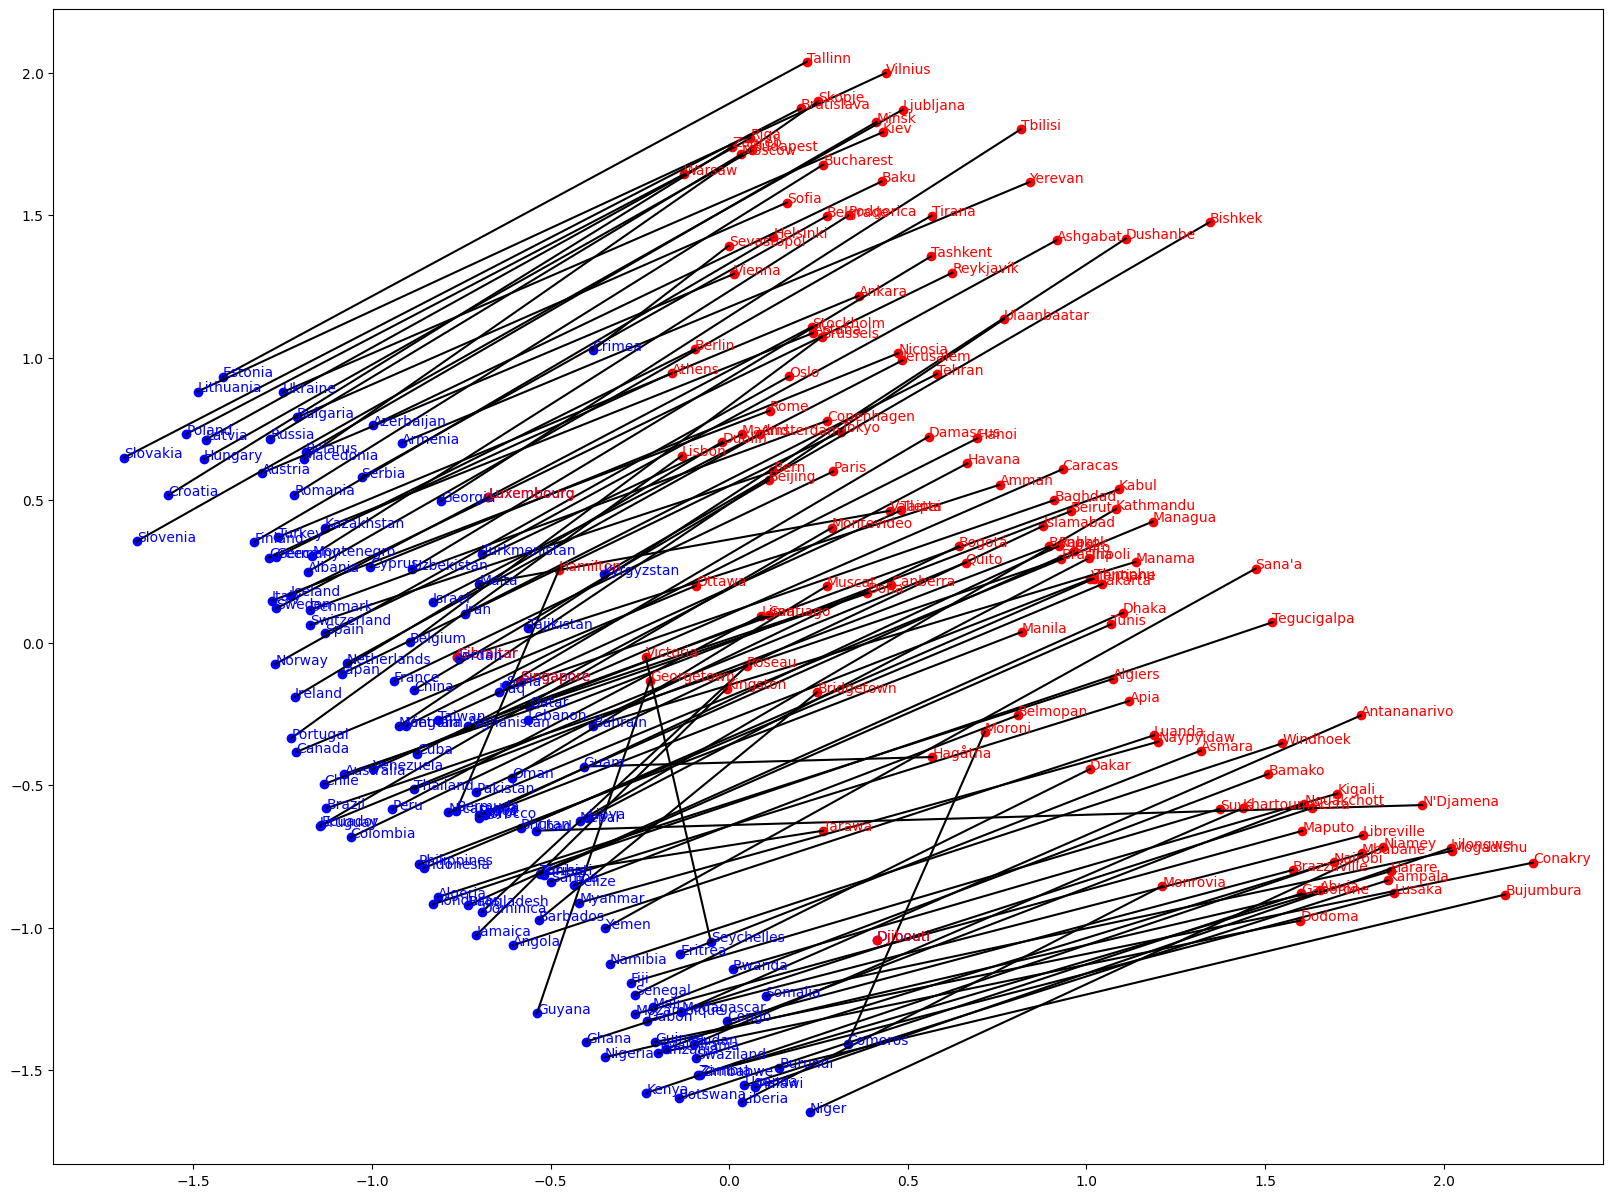

In [ ]:
plt.figure(figsize=(20,15))

for i in range(0, len(geo), 2):
    country = X[i]
    capital = X[i + 1]
    
    plt.plot((country[0], capital[0]), (country[1], capital[1]), c='black')
    plt.scatter(x = country[0], y = country[1], c='b')
    plt.scatter(x = capital[0], y = capital[1], c='r')

for i in range(0, len(geo), 2):
    country = X[i]
    capital = X[i + 1]
    
    plt.annotate(text = geo[i], xy = (country[0], country[1]), c='b')

    plt.annotate(text = geo[i + 1], xy = (capital[0], capital[1]), c='r')

plt.show() 

## Task 5.4

In [ ]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext.word2idx[w] for w in top_words]


#
# TODO: make a 2D PCA projection of the selected words.
#

In [ ]:
from sklearn.manifold import TSNE

#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#


In [ ]:
# TODO: zomm in on 3 meaningful clusters